In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import getdist
from getdist import loadMCSamples, plots
import warnings
from copy import deepcopy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# GENERAL PLOT OPTIONS
# GENERAL PLOT OPTIONS
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.major.width'] = 1.2
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 0.8
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = '1.0'
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.linewidth'] = '0.0'
matplotlib.rcParams['grid.alpha'] = '0.18'
matplotlib.rcParams['grid.color'] = 'lightgray'
matplotlib.rcParams['legend.labelspacing'] = 0.77
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['legend.title_fontsize'] = 18
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['savefig.dpi'] = 300

from scipy.interpolate import interp1d
from scipy.integrate import quad

In [9]:
dv_filepaths = [
    './data/roman_baseline_evaluate/roman.modelvector',
    './data/roman_limber_evaluate/roman.modelvector',
    './data/roman_noRSD_evaluate/roman.modelvector',
    './data/roman_takahashi_evaluate/roman.modelvector',
    './data/roman_hmcode20_evaluate/roman.modelvector',
    './data/roman_limber_noRSD_takahashi_evaluate/roman.modelvector',
]
cov_filepath = './data/cov_roman_fourier'
Y3mask_filepath = './data/roman_Y3.mask'
SRDmask_filepath = './data/roman_SRD.mask'

dvs = []
for i in range(len(dv_filepaths)):
    dvs.append(np.loadtxt(dv_filepaths[i])[:,1]) 
dvs = np.array(dvs)

cov_raw = np.loadtxt(cov_filepath)
ncov = int(np.max(cov_raw[:,0])+1)
cov = np.zeros((ncov, ncov))
for i in range(len(cov_raw)):
    ii = int(cov_raw[i,0])
    jj = int(cov_raw[i,1])
    element = cov_raw[i,8] + cov_raw[i,9]
    cov[ii,jj] = element
    cov[jj,ii] = element
    
y3mask = np.loadtxt(Y3mask_filepath)[:,1].astype(bool)
srdmask = np.loadtxt(SRDmask_filepath)[:,1].astype(bool)

chi2s_origin, chi2s_y3mask, chi2s_srdmask = [], [], []
invcov = np.linalg.pinv(cov)
invcov_y3 = np.linalg.pinv(cov[y3mask,:][:,y3mask])
invcov_srd = np.linalg.pinv(cov[srdmask,:][:,srdmask])
for i in range(len(dv_filepaths)):
    chi2s_origin.append((dvs[i]-dvs[0])@invcov@(dvs[i]-dvs[0]))
    chi2s_y3mask.append((dvs[i]-dvs[0])[y3mask]@invcov_y3@(dvs[i]-dvs[0])[y3mask])
    chi2s_srdmask.append((dvs[i]-dvs[0])[srdmask]@invcov_srd@(dvs[i]-dvs[0])[srdmask])


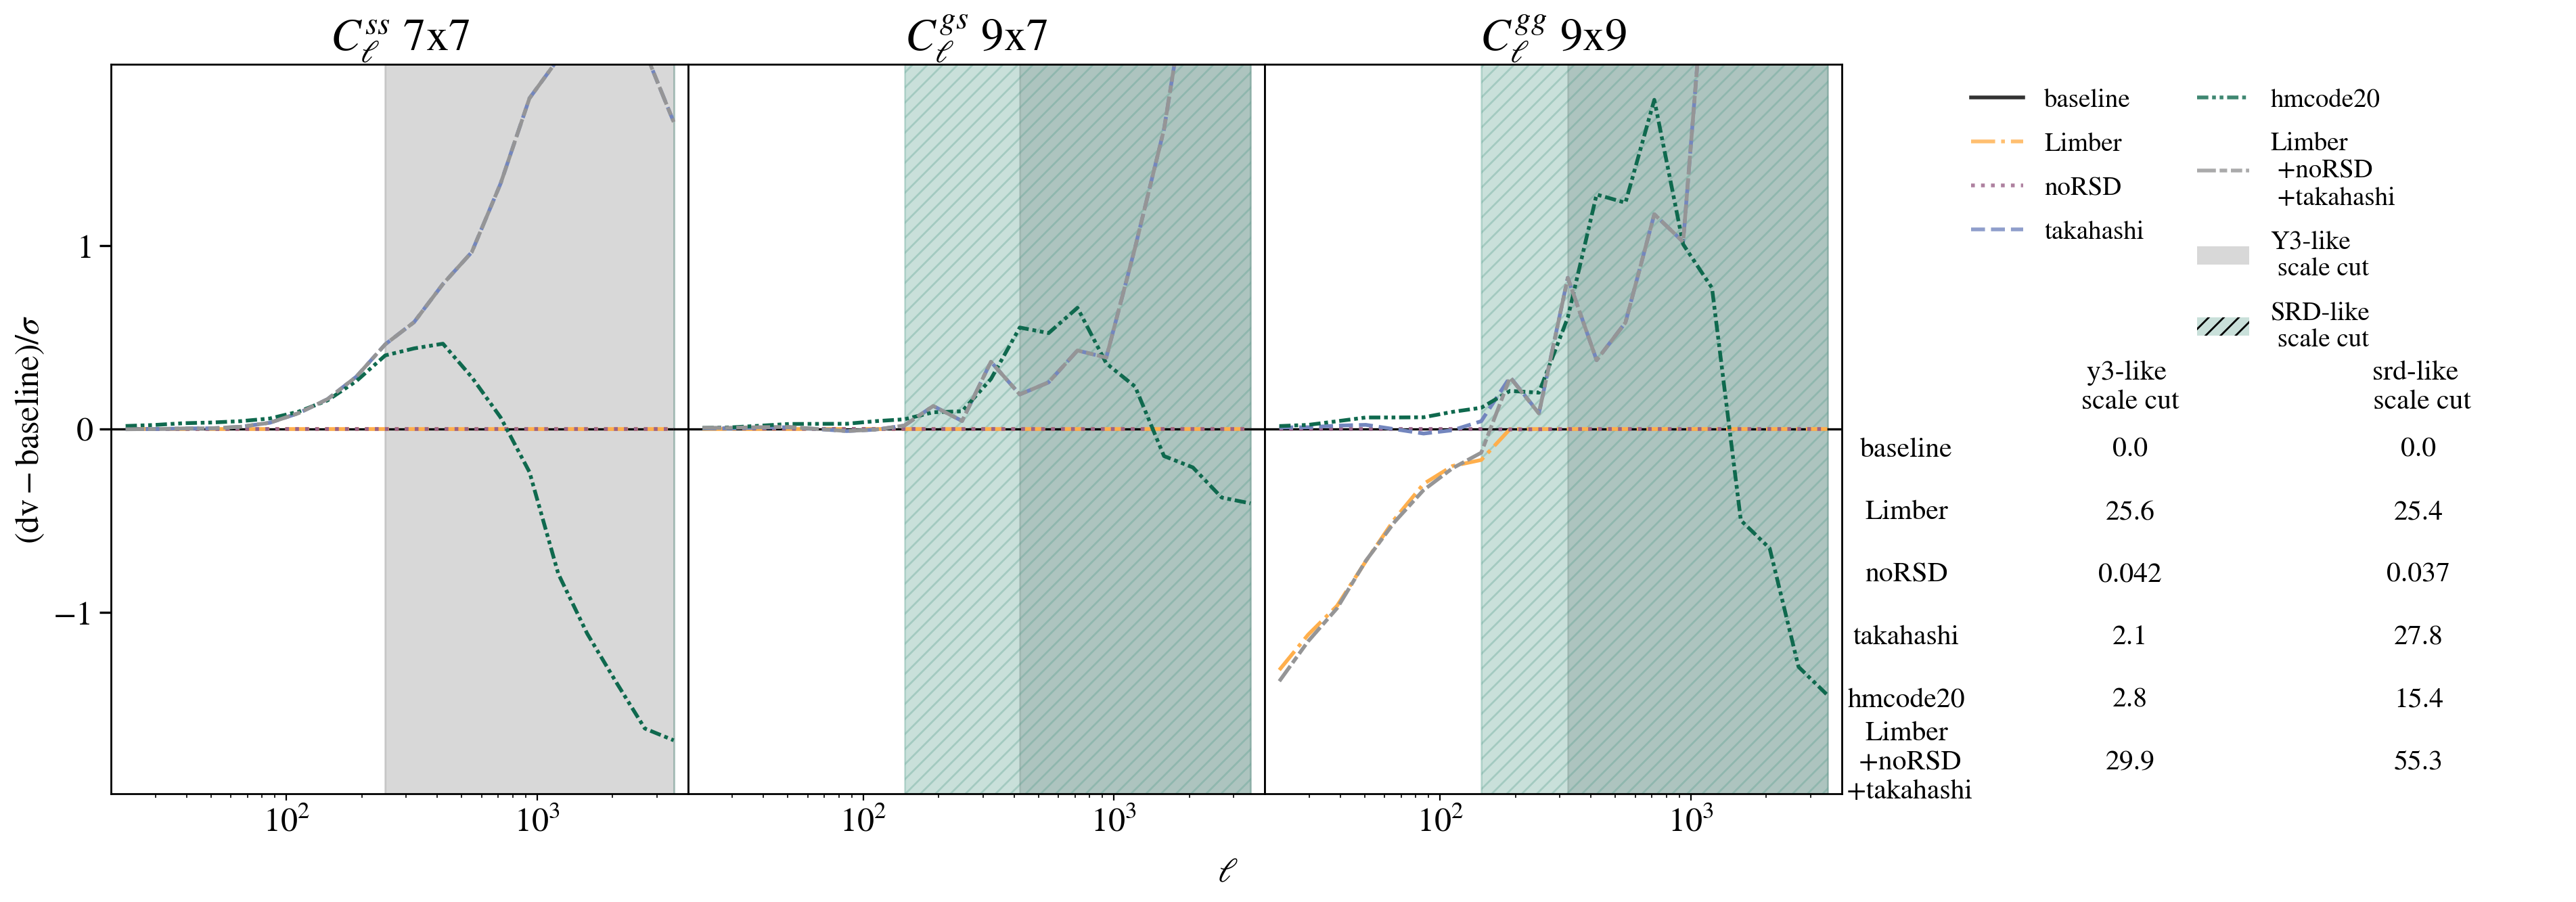

In [10]:
nlens = 10
nsrcs = 8
ncl = 20

#ell used in COCOA
lmin = 20
lmax = 4000
logdl = (np.log(lmax) - np.log(lmin))/ncl
ell = np.zeros(int(ncl))
for i in range(int(ncl)):
    ell[i] = np.exp(np.log(lmin) + (i + 0.5)*logdl)

probe_start = {'C_ss':0, 'C_gs':int(nsrcs*(nsrcs+1)/2), 'C_gg':int(nsrcs*(nsrcs+1)/2+nlens*nsrcs),}
def Ncombo(probe, ni, nj):
    start = probe_start[probe]
    sub_cnt = 0
    if probe == 'C_ss':
        for i in range(nsrcs):
            for j in range(i,nsrcs):
                if(i,j)==(ni,nj):
                    break
                sub_cnt+=1
                
    if probe == 'C_gs':
        for i in range(nlens):
            for j in range(nsrcs):
                if(i,j)==(ni,nj):
                    break
                sub_cnt+=1
                
    if probe == 'C_gg':
        for i in range(nlens):
            if (i,i) == (ni,nj):
                break
            sub_cnt+=1
            
    return start+sub_cnt

ls_list = ['-', '-.', ':', '--', (0, (3,1,1,1,1,1)), (0, (5, 1, 2, 1, 3, 1))]
c_list  = ['k', '#FFAF4C', '#9A6289', '#7386BE', '#0F694E', '#959596']
labels  = ['baseline', 'Limber', 'noRSD', 'takahashi', 'hmcode20', 'Limber\n +noRSD\n +takahashi']
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
handles = [
    Line2D([0], [0], ls=ls_list[i], lw=2, color=c_list[i],alpha=0.8, label=labels[i]) \
        for i in range(len(ls_list))
]
patch_handles = [
    Patch(facecolor='gray', alpha=0.3, label='Y3-like\n scale cut'),
    Patch(facecolor='#4C9987', alpha=0.3, hatch='///', label='SRD-like\n scale cut')
]
latexs = {'C_ss':r'$C_\ell^{ss}$', 'C_gs':r'$C_\ell^{gs}$', 'C_gg':r'$C_\ell^{gg}$',}
def plot_single(
    ax,
    dvs,
    probe,
    ni,
    nj,
):
    assert probe in ['C_ss', 'C_gs', 'C_gg']
    assert ni>=0 and nj>=0
    assert ni<10 and nj<10
    assert type(ni) == int and type(nj) == int
    
    #fetch the segment of dv and cov
    ncombo = Ncombo(probe,ni,nj)
    l,r = ncombo*ncl, (ncombo+1)*ncl
    dv_seg = dvs[:, l:r]
    cov_seg = cov[l:r,:][:,l:r]
    sigmas_seg = np.sqrt(np.array([cov_seg[i,i] for i in range(len(cov_seg))]))
    y3mask_seg = y3mask[l:r].astype(bool)
    srdmask_seg = srdmask[l:r].astype(bool)
    
    baseline = dv_seg[0]
    #plot reference line and shadow of mask
    ax.axhline(y=0.0, color='k',ls='-',linewidth=1.2)
    ax.axvspan(ell[-1] if ell[~y3mask_seg].size == 0 else ell[~y3mask_seg][0], ell[-1], color='gray', alpha=0.3, )
    ax.axvspan(ell[-1] if ell[~srdmask_seg].size == 0 else ell[~srdmask_seg][0], ell[-1], color='#4C9987', alpha=0.3, hatch='///')
    invcov_seg = np.linalg.pinv(cov_seg)
    chi2s = []
    for i in range(1, len(dv_seg)):
        y = (dv_seg[i] - baseline)/sigmas_seg
        ax.plot(ell, y, linestyle=ls_list[i],color = c_list[i],lw=2)
        
        chi2s.append((dv_seg[i] - baseline)@invcov_seg@(dv_seg[i] - baseline))
        
    ax.set_xlim(20+0.01, 4000-0.01)
    ax.set_xscale('log')
    ax.set_ylim(-2+0.01,2-0.01)
    ax.set_title(latexs[probe]+f' {ni}x{nj}')
    
    return chi2s


fig,axs = plt.subplots(1,4, figsize=(22,7), gridspec_kw={'width_ratios':[2,2,2,2]})
fig.supxlabel(r'$\ell$', fontsize=18)
plt.subplots_adjust(wspace=0.00)
for i in range(1,4):
    axs[i].tick_params(axis='y', which='both', left=False,labelleft=False)
plot_single(axs[0], dvs, probe='C_ss',ni=7,nj=7)
plot_single(axs[1], dvs, probe='C_gs',ni=9,nj=7)
plot_single(axs[2], dvs, probe='C_gg',ni=9,nj=9)

axs[0].set_ylabel(r'$(\mathrm{dv} - \mathrm{baseline})/\sigma$')
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
axs[0].yaxis.set_major_locator(MultipleLocator(1))

axs[-1].axis('off')
axs[-1].tick_params(axis='y', which='both', left=False,labelleft=False)
axs[-1].tick_params(axis='x', which='both', bottom=False,labelbottom=False)
axs[-1].legend(handles=handles+patch_handles, frameon=False,loc='upper right',ncol=2)

row_labels = labels
col_labels = [ 'y3-like \nscale cut', 'srd-like \n scale cut']
cell_text = []
for i in range(len(labels)):
    if i==2:
        cell_text.append([ f'{chi2s_y3mask[i]:.3f}', f'{chi2s_srdmask[i]:.3f}'])
    else:
        cell_text.append([ f'{chi2s_y3mask[i]:.1f}', f'{chi2s_srdmask[i]:.1f}'])
tbl = axs[-1].table(
    cellText=cell_text,
    rowLabels=row_labels,
    colLabels=col_labels,
    cellLoc='center',
    rowLoc='center',
    bbox=[0.25, 0.0, 1.0, 0.60], 
    edges='open',
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(15)
tbl.scale(1.0,0.5)

plt.savefig('3x2pt_dv_comparison.jpg', dpi=300)

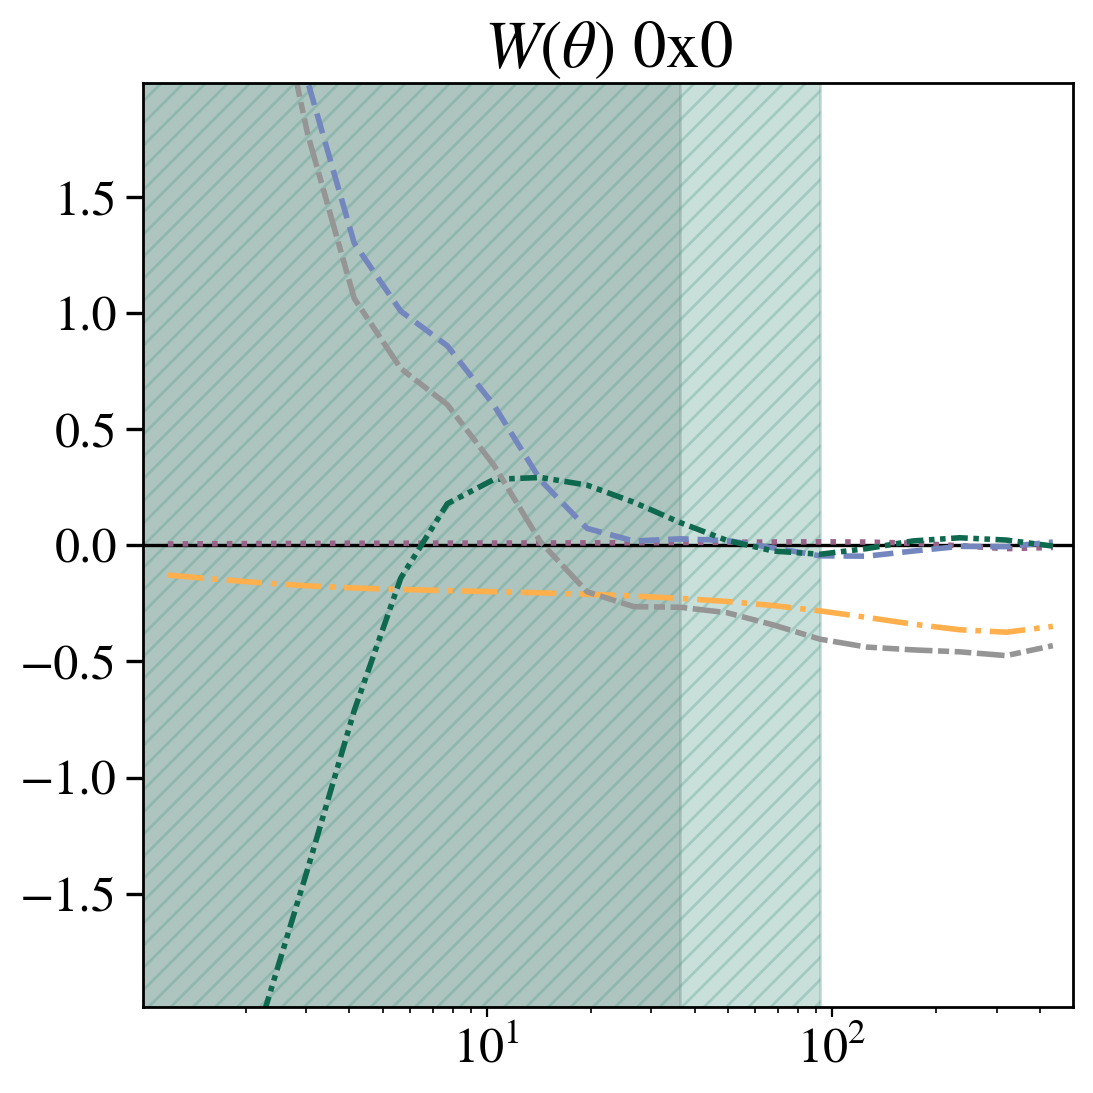

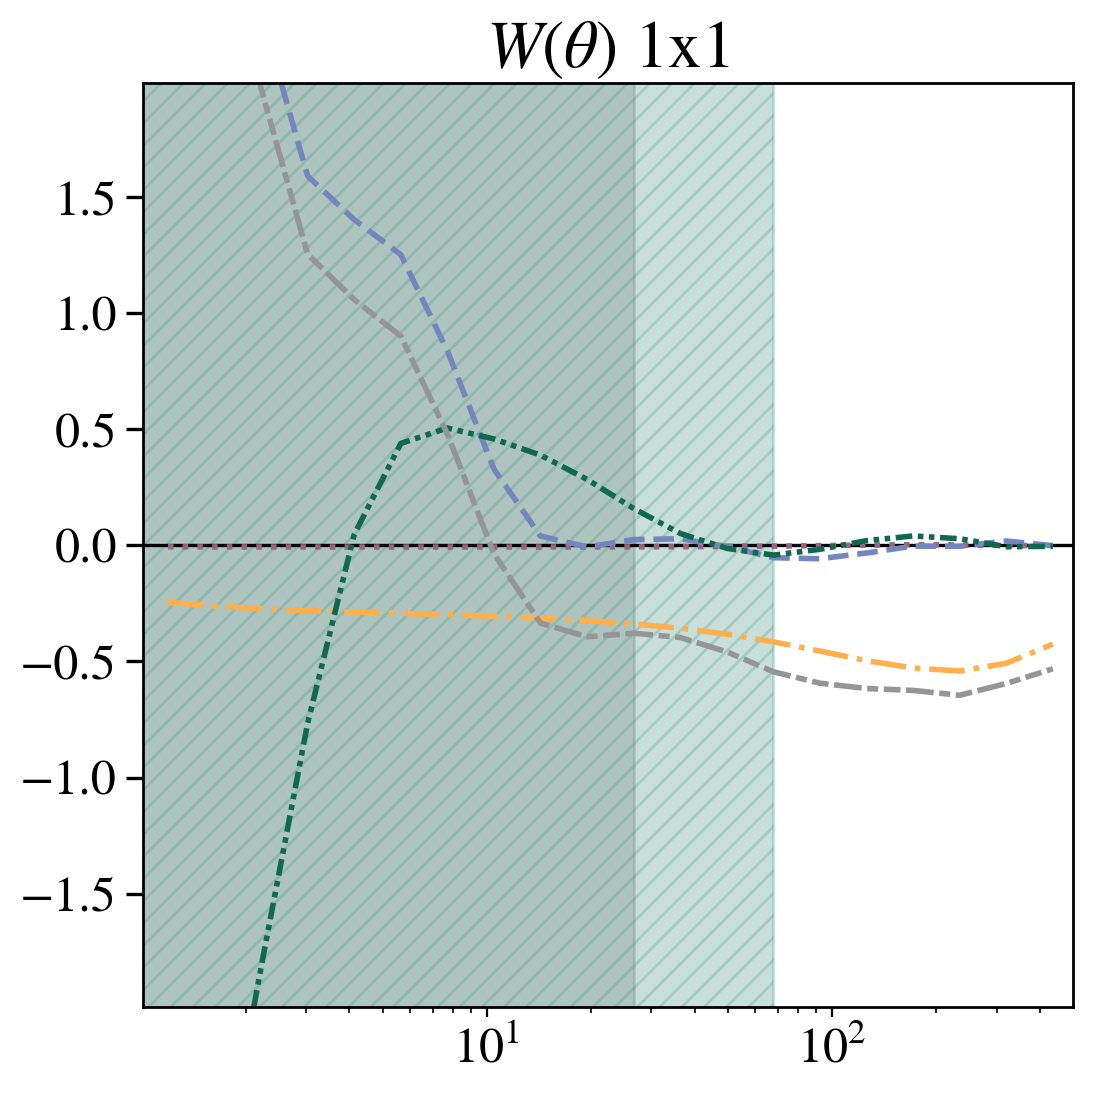

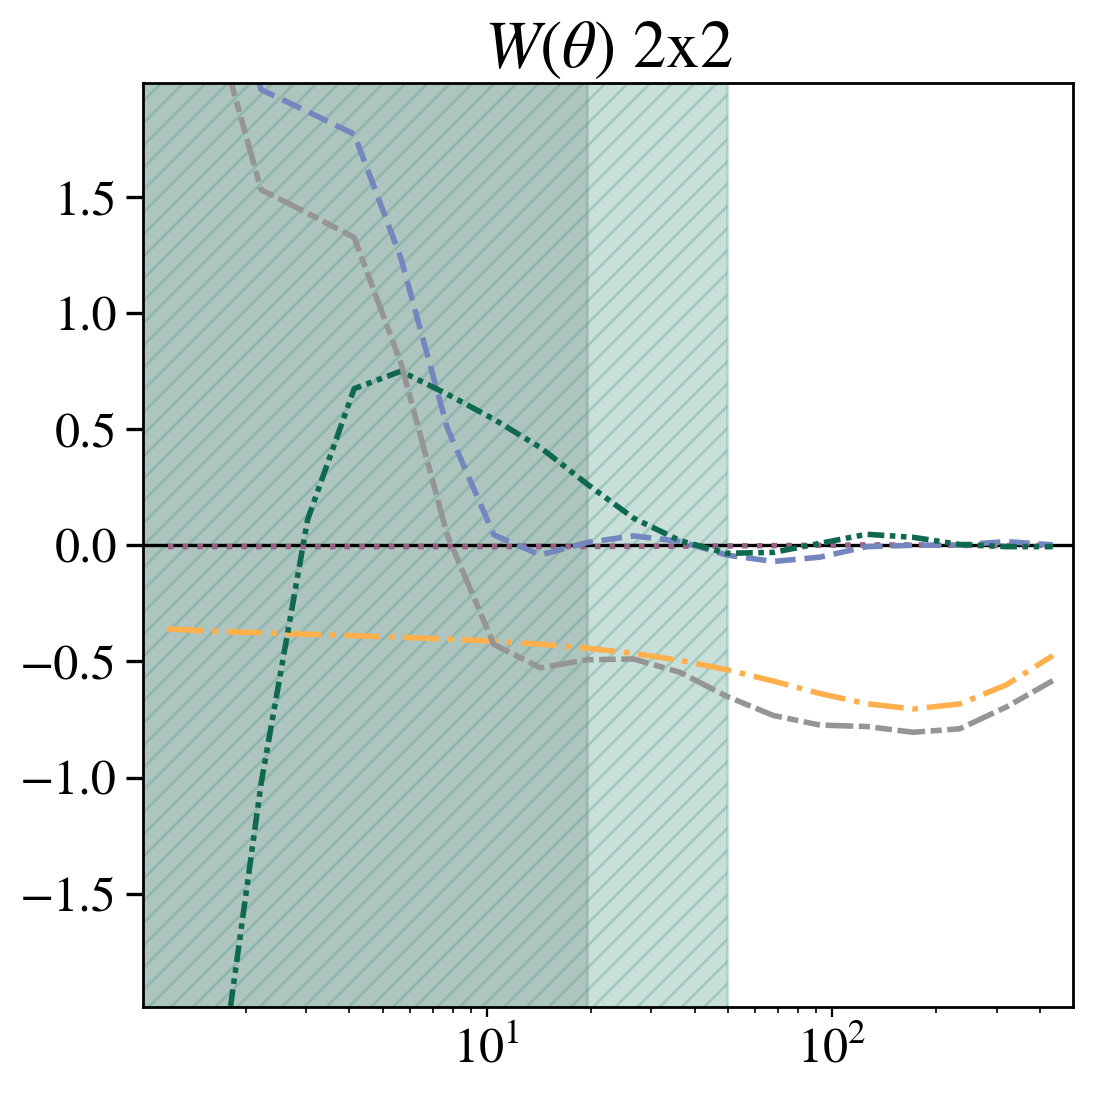

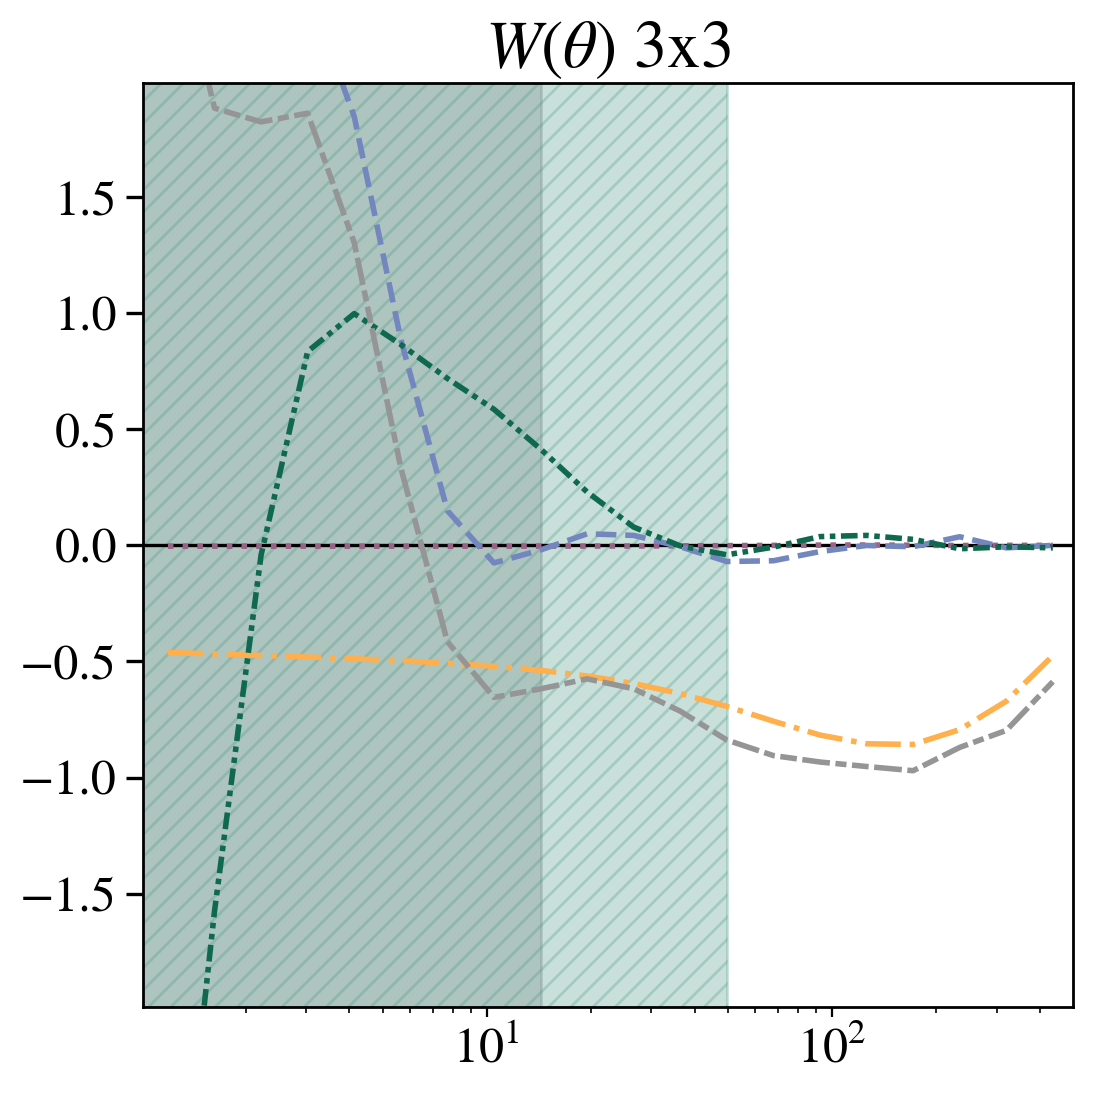

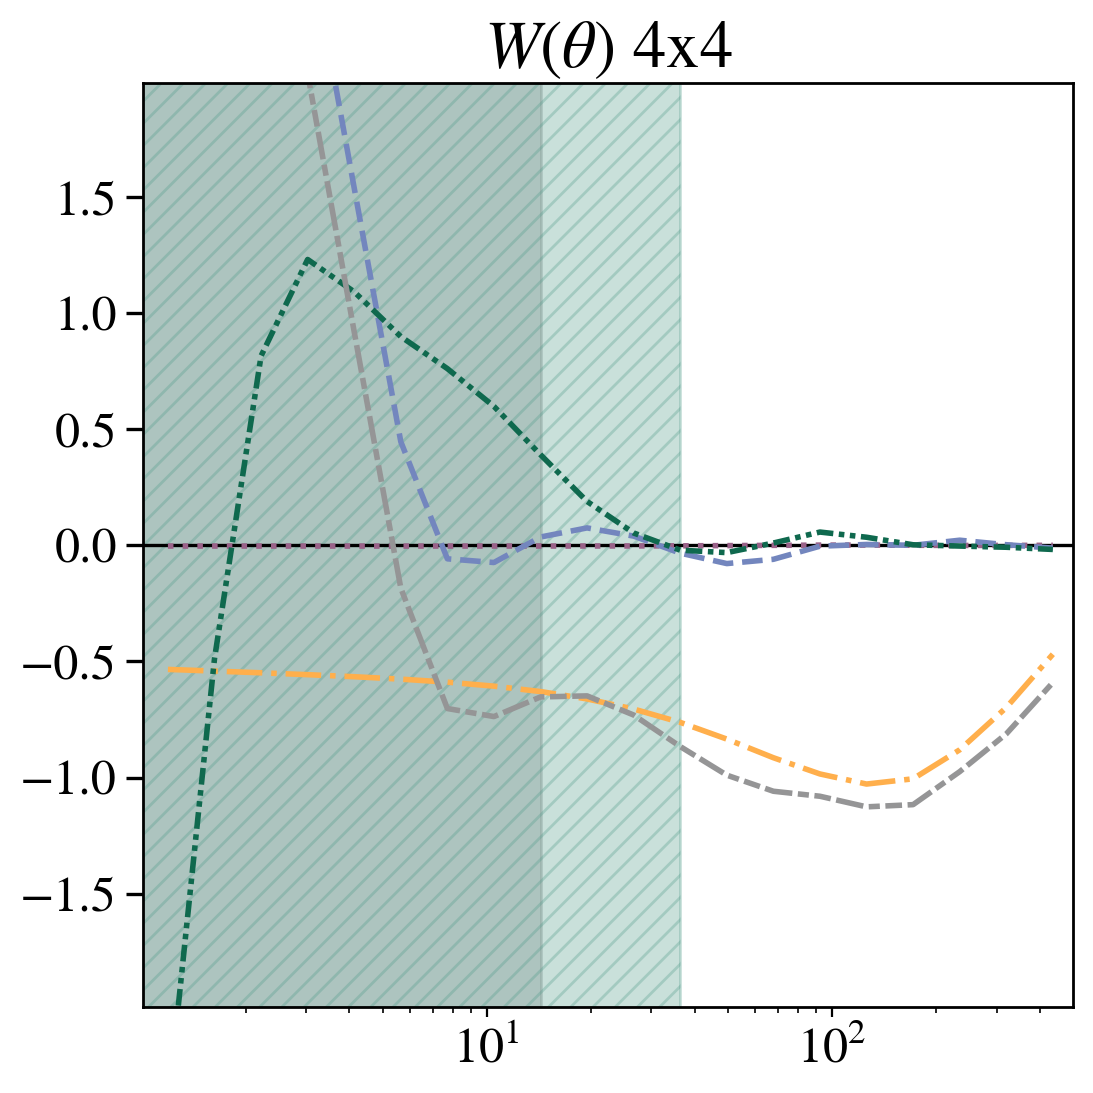

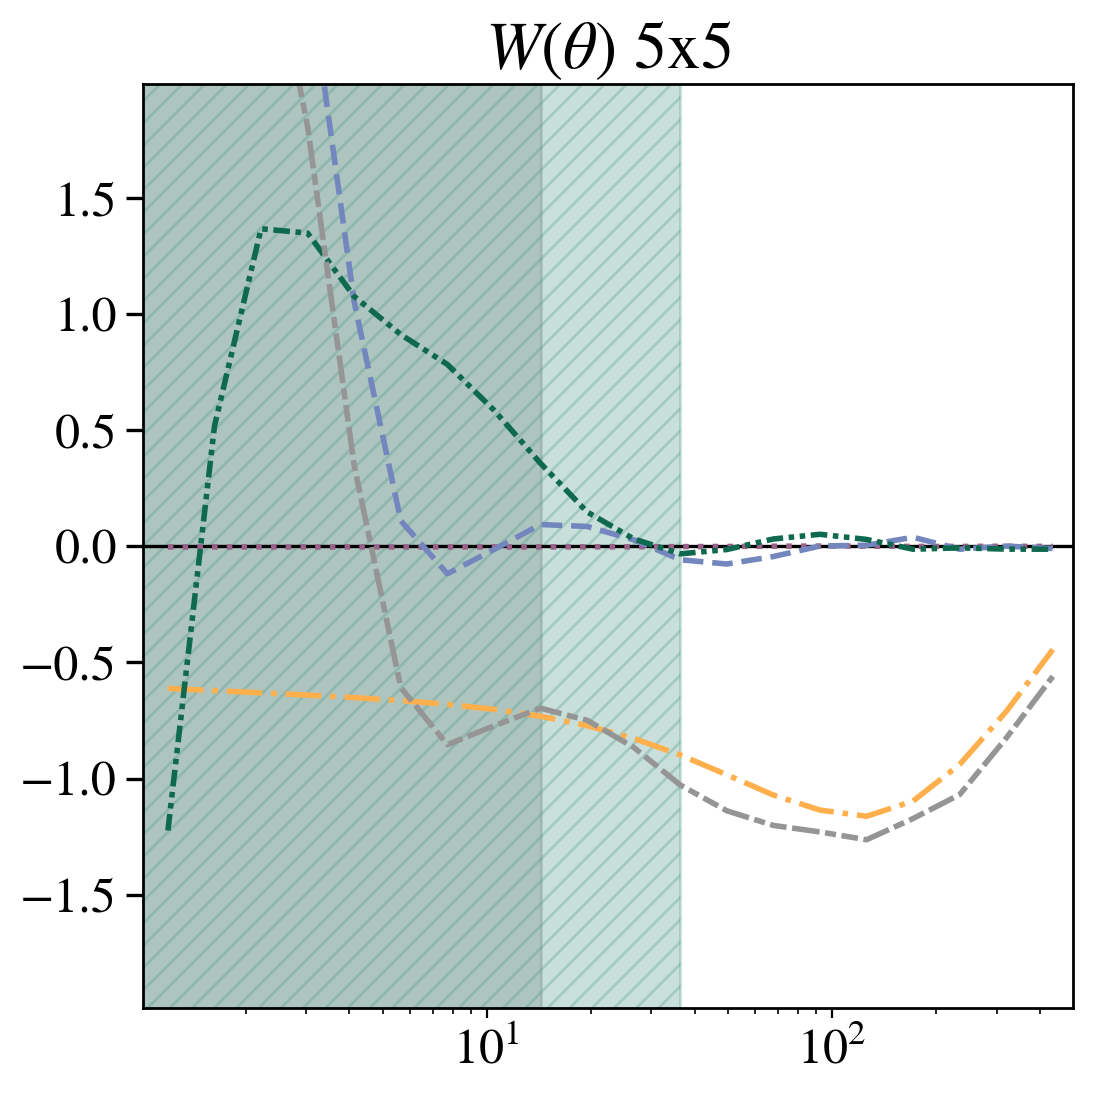

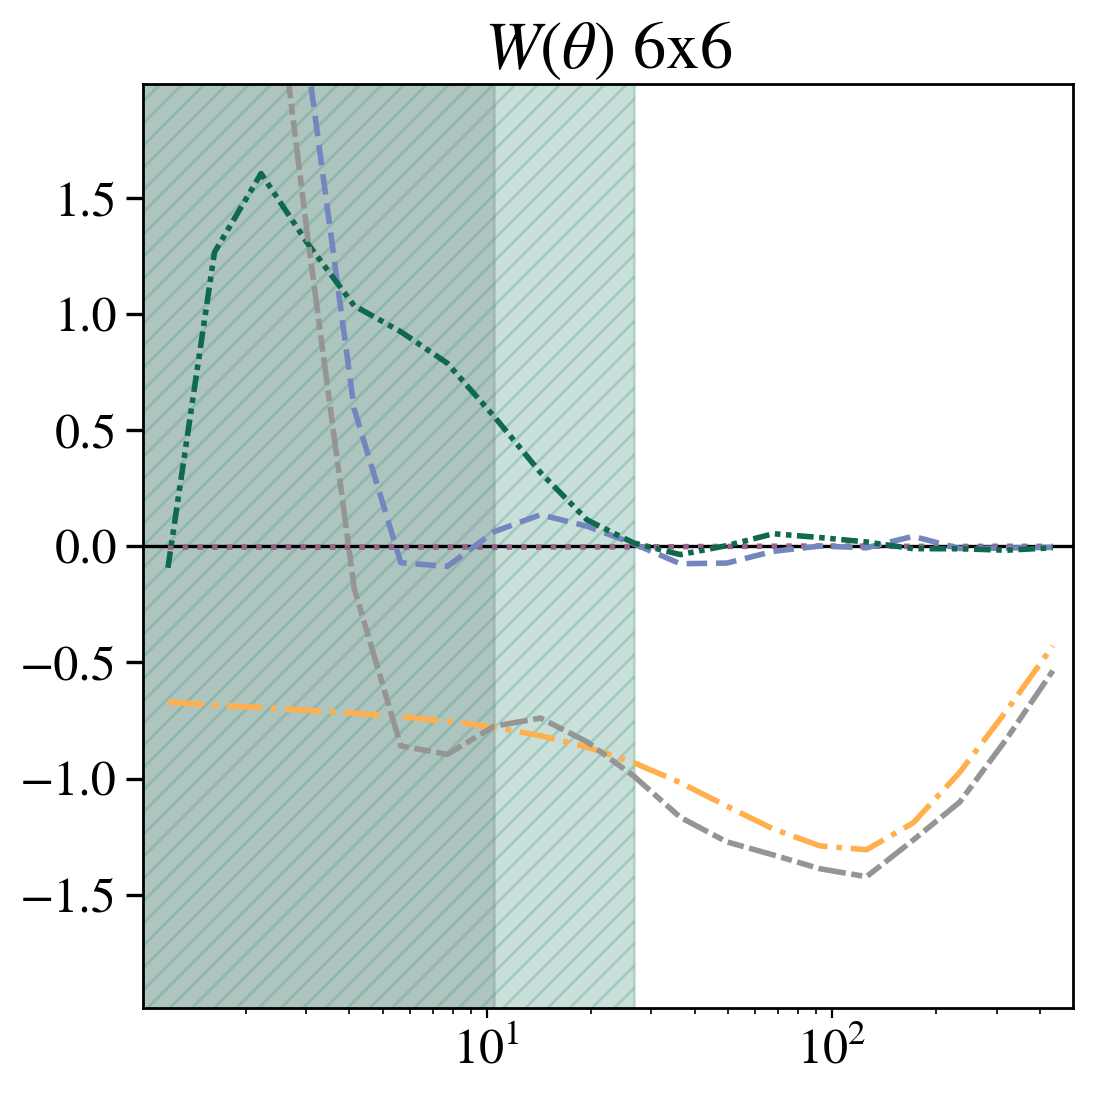

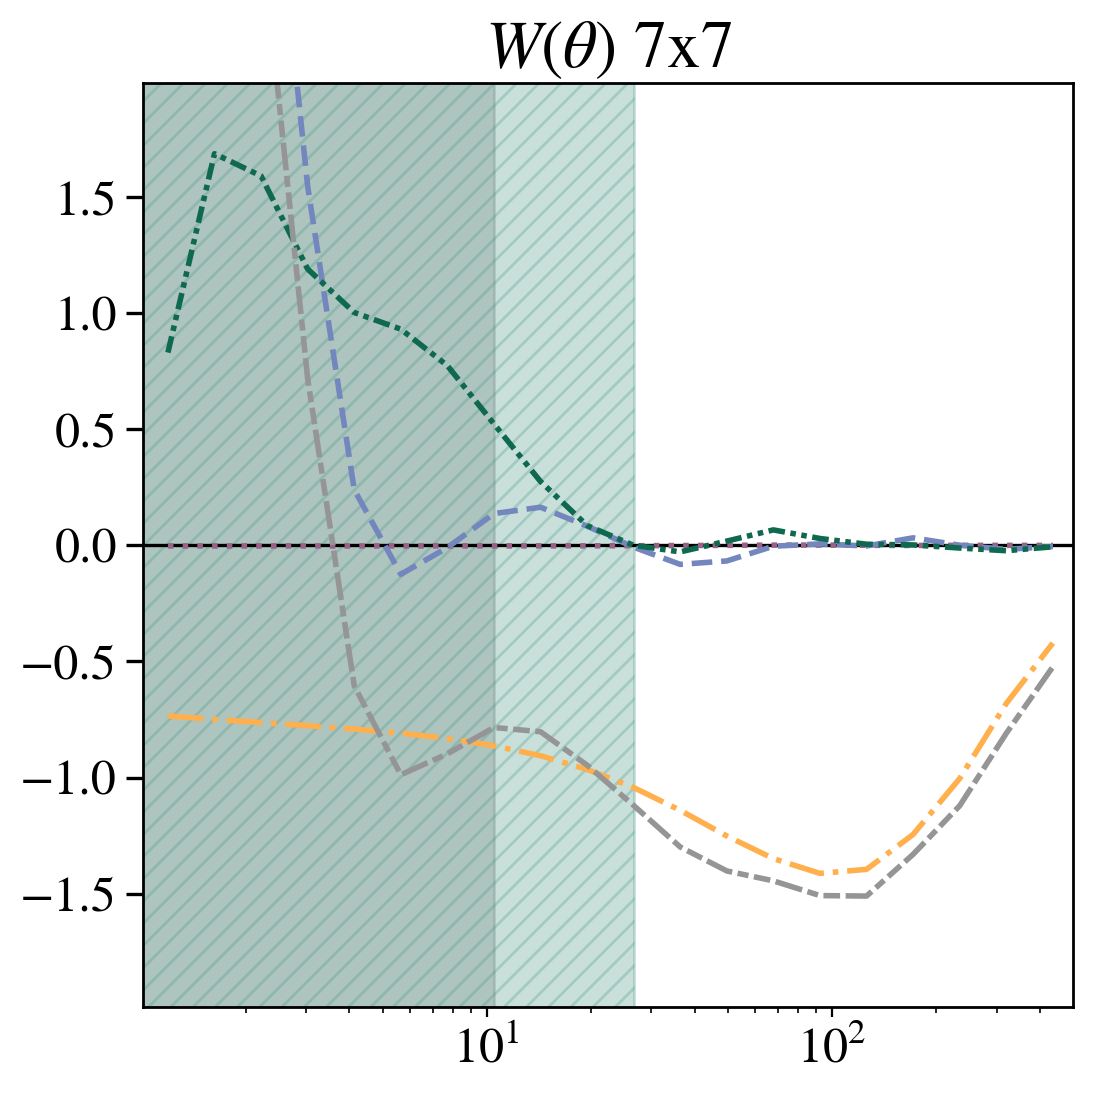

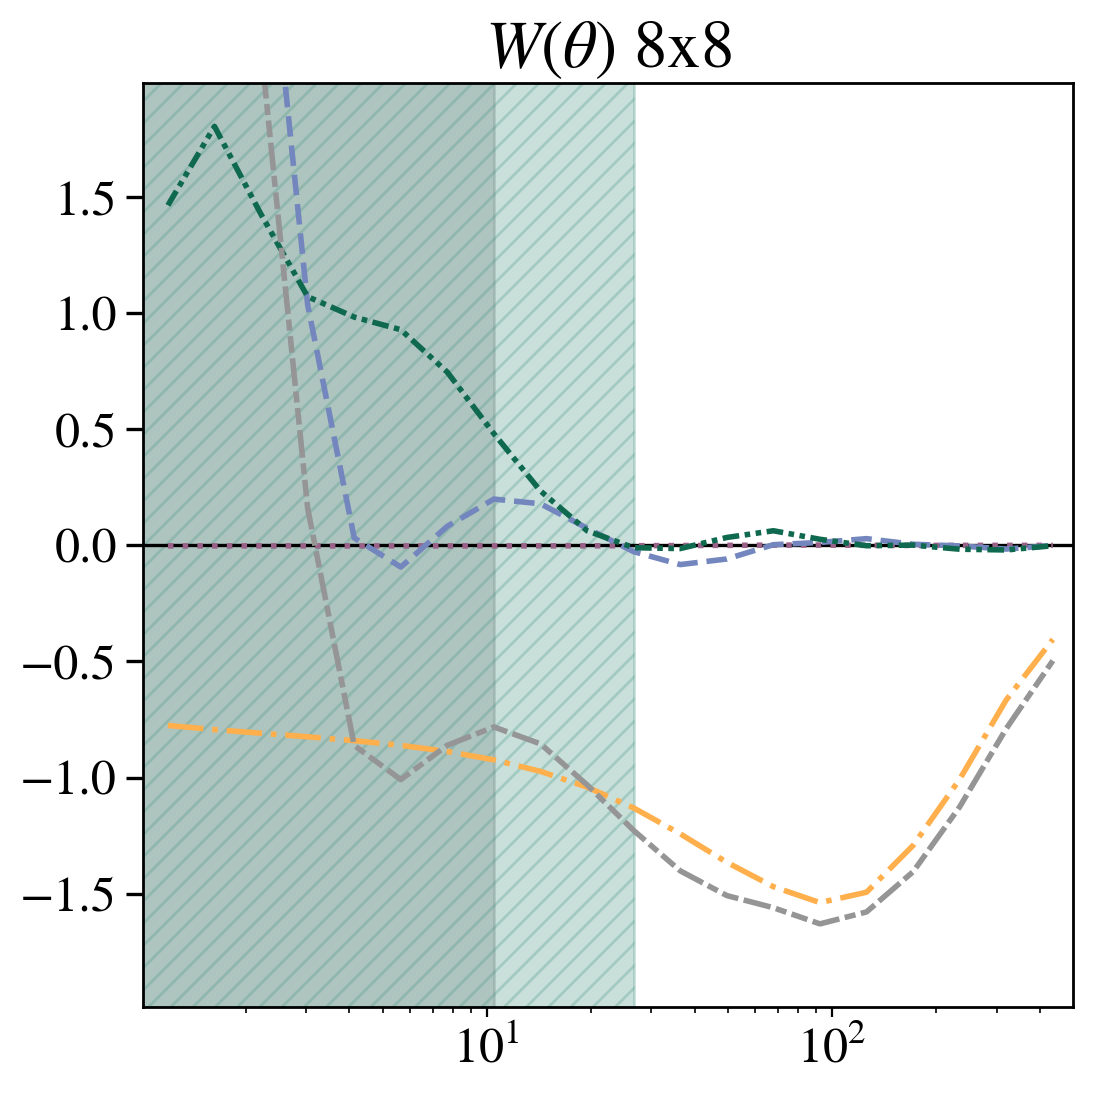

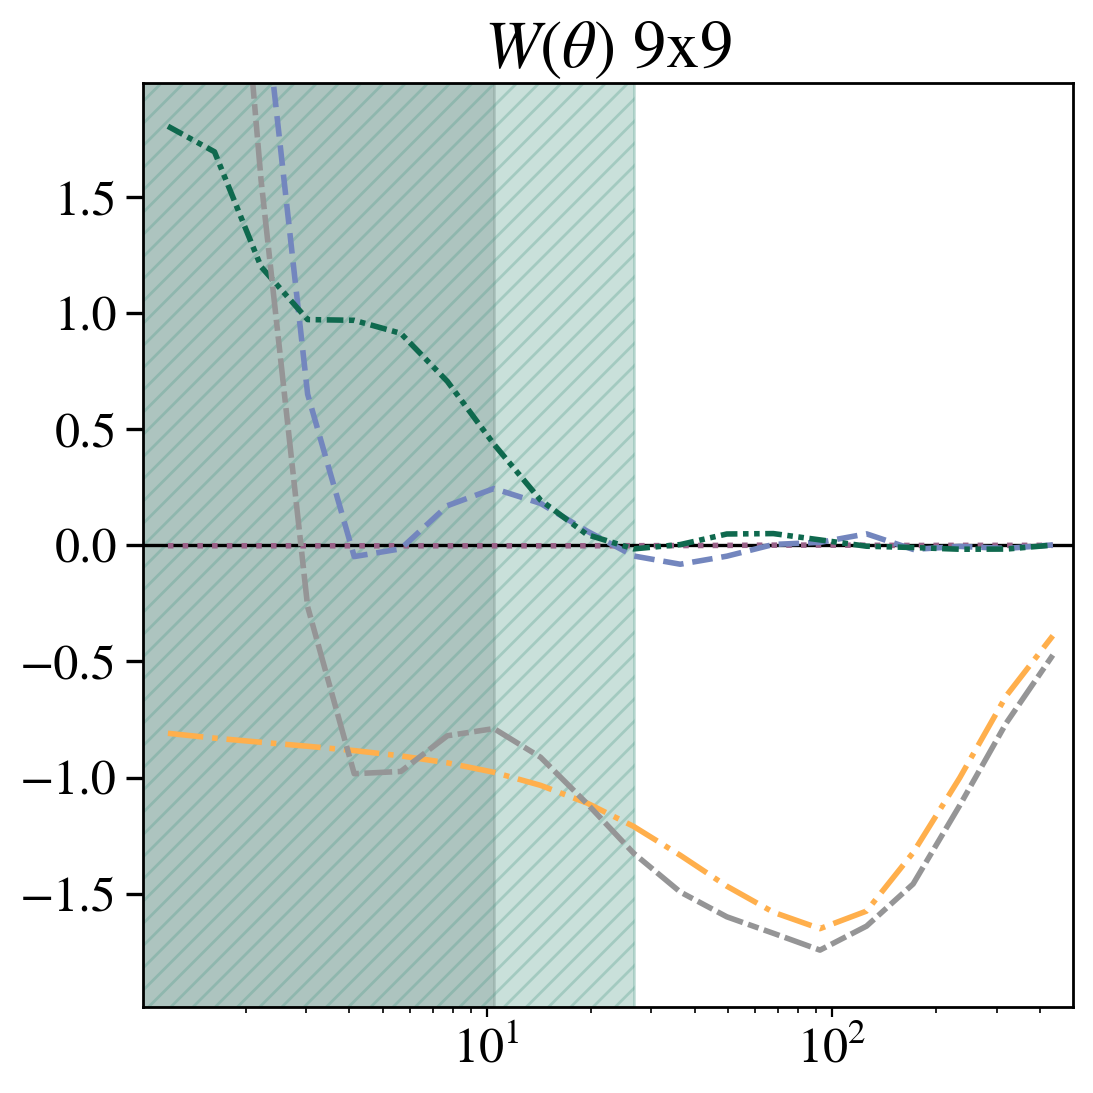

Max = 0; Maxi = 9; Maxj = 7


In [54]:
Max = 0
Maxi, Maxj = 0, 0

for i in range(nlens):
    fig,ax = plt.subplots(1,1, figsize=(6,6))
    chi2s = plot_single(ax, dvs, probe='wtheta',ni=i,nj=i)
    sumchi2s = np.sum(chi2s)
    if (sumchi2s>Max):
        Maxi = i
        Maxj = j
    plt.show()

print(f'Max = {Max}; Maxi = {Maxi}; Maxj = {Maxj}')